<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningResNet50_sourceLight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
@authors: LorenzoVisentini and Gianmarco Bolcato
"""

modelName = "ResNet50"

#import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#keras
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.utils import plot_model

import random
random.seed(42)

Using TensorFlow backend.


In [2]:
# link with Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Images parameters
img_target_size = (224, 224)
shape = (224, 224, 3)

# Jupyter notebook paths
train_dir = './orient/train'
val_dir = './orient/val' 
test_dir = './orient/test' 

# Google Colab paths
# train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/train'
# val_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/val' 
# test_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/test' 

In [4]:
n_classes = 3

# Hyperparameters
batch_size = 32
epochs = 10
drop_rate = 0.6
lr = 0.005


# variable to check if it's applied the batchNormalization patch
patch = True

# file_model = '/content/drive/My Drive/Deep Learning Project - Image Classification/Models/'+ modelName + 'OR' + '_Bs' + str(batch_size) + '_Ep' + str(epochs) + '_Dr' + str(drop_rate) + '_Lr' + str(lr)
file_model = modelName + 'OR' + '_Bs' + str(batch_size) + '_Ep' + str(epochs) + '_Dr' + str(drop_rate) + '_Lr' + str(lr)
if patch == True:
    file_model = file_model + '_patched'

In [5]:
# from https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
# https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

# Transfer learning on ResNet50 model
# use all the layers except for the last fully connected layer (because its 
# specific to the ImageNet competition)
# we will retrain layers with new inputs
pre_trained_model = ResNet50(input_shape = shape,
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check ResNet50 structure

C:\Users\Sviluppo\anaconda3\envs\deeplearning\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
#transfer learning phase
x = pre_trained_model.output

# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation= 'relu')(x)
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)

x = Dropout(drop_rate)(x)
x = Dense(128, activation= 'relu')(x)
output = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = output)

#freeze the model excepted added layers
# for layer in pre_trained_model.layers:
#     layer.trainable = False
    
#because of BN normalization problem: https://github.com/keras-team/keras/issues/9214
for layer in pre_trained_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

# custom optimizer
opt = optimizers.Adam(learning_rate=lr)

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [ ]:
# plot model tree
tree_path = './ModelTrees/'
if os.path.exists(tree_path) == False:
    os.makedirs(tree_path)
else: 
    print('Folder Plots already exists')
plot_model(model, to_file=f"{tree_path}/{file_model}.png", show_layer_names=True, show_shapes=True)

In [7]:
# preprocessing
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

train_gen = ImageDataGenerator(width_shift_range=[0,0.2],
                            height_shift_range=[0,0.2],
                            zoom_range=[0.8,1.0],
                            fill_mode="nearest")
# train_gen = ImageDataGenerator()

# Set aug variable to save if the model used data augmentation or not
aug = True
if aug == True:
    modelName = modelName+'Aug'

test_gen = ImageDataGenerator()

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_generator = test_gen.flow_from_directory(directory=val_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

test_generator = test_gen.flow_from_directory(directory = test_dir,
                                                    target_size = img_target_size,
                                                    color_mode="rgb",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42
                                                )

Found 7135 images belonging to 3 classes.
Found 1529 images belonging to 3 classes.
Found 1530 images belonging to 3 classes.


In [8]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//batch_size,
                             epochs = epochs,
                             validation_data = val_generator,
                             validation_steps = val_generator.n//batch_size
                             )

Epoch 1/10
222/222 [==============================] - 114s 514ms/step - loss: 0.7748 - accuracy: 0.6890 - val_loss: 0.6101 - val_accuracy: 0.8398
Epoch 2/10
222/222 [==============================] - 103s 463ms/step - loss: 0.3841 - accuracy: 0.8468 - val_loss: 0.3872 - val_accuracy: 0.8390
Epoch 3/10
222/222 [==============================] - 102s 462ms/step - loss: 0.3446 - accuracy: 0.8665 - val_loss: 0.2072 - val_accuracy: 0.8684
Epoch 4/10
222/222 [==============================] - 103s 462ms/step - loss: 0.3167 - accuracy: 0.8750 - val_loss: 0.5617 - val_accuracy: 0.8664
Epoch 5/10
222/222 [==============================] - 103s 463ms/step - loss: 0.3127 - accuracy: 0.8775 - val_loss: 0.2310 - val_accuracy: 0.8764
Epoch 6/10
222/222 [==============================] - 103s 462ms/step - loss: 0.2924 - accuracy: 0.8855 - val_loss: 0.3466 - val_accuracy: 0.8711
Epoch 7/10
222/222 [==============================] - 103s 464ms/step - loss: 0.2808 - accuracy: 0.8896 - val_loss: 0.4638 -

In [10]:
# consider highlight the different values of hyperparameters used
# OR orient o SL source light, Bs batch size, Ep epochs, Dr drop rate, Lr learning rate
# CHECK ALWAYS BOOLEAN PATCH VALUES (on top)

# create models folder if doesn't exist
path_models = './Models/'
if os.path.exists(path_models) == False:
    os.makedirs(path_models)
else: 
    print('Folder Models already exists')
    
# save model and history
model.save(path_models + file_model + '.h5')
print(file_model)

#save history
# create models folder if doesn't exist
path_history = './History/'
if os.path.exists(path_history) == False:
    os.makedirs(path_history)
else: 
    print('Folder History already exists')
file_hist = path_history + file_model + '.csv'
df_history = pd.DataFrame(history.history)
with open(file_hist, 'w') as file:
    df_history.to_csv(file)
print(file_hist)

Folder Models already exists
./Models/ResNet50AugOR_Bs32_Ep10_Dr0.6_Lr0.005_patched
./Models/ResNet50AugOR_Bs32_Ep10_Dr0.6_Lr0.005_patched.csv


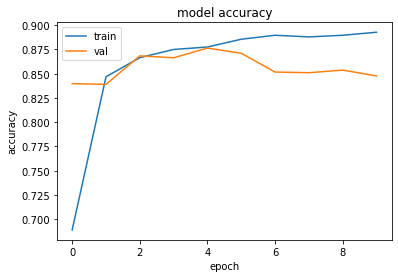

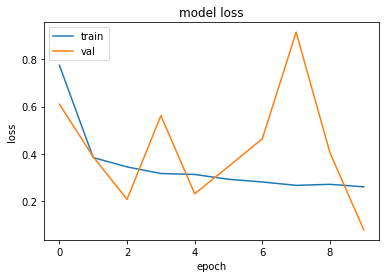

In [9]:
# Plot path
plot_path = './Plots/'
if os.path.exists(plot_path) == False:
    os.makedirs(plot_path)
else: 
    print('Folder Plots already exists')
plot_file = plot_path + file_model + '.png'

#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.savefig(plot_file)

In [11]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = test_generator.n // test_generator.batch_size
accuracy_ontest = model.evaluate_generator(test_generator, steps)
print(accuracy_ontest)

[0.6234421133995056, 0.8530585169792175]
